In [1]:
import pandas as pd
import numpy as np
pd.set_option('max.rows',200)
import time

## Train & Evaluate Model in US

### Load data

In [ ]:
np.seed(0)

In [2]:
train = pd.read_csv('../data/processed/us-train.csv')
val = pd.read_csv('../data/processed/us-val.csv')
us = pd.read_csv('../data/processed/us-test.csv')

In [3]:
y_train = train.log_price
y_val = val.log_price

In [4]:
X_train = train.drop(columns=['log_price'])
X_val = val.drop(columns=['log_price'])

### Train Random Forest

### Default Parameters

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [6]:
rf = RandomForestRegressor().fit(X_train, y_train)

In [7]:
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_val)

acc_train = rf.score(X_train, y_train)
acc = rf.score(X_val, y_val)

rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_val), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_val), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y_train), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_val), np.exp(y_pred))

In [8]:
print('R^2 (Train):', round(acc_train,2)) 
print('R^2 (Val):', round(acc,2))
print('')
print('RMSE (Train):', round(rmse_train,2))
print('RMSE (Val):', round(rmse,2))
print('')
print('Mean Abs Error (Train):', round(mae_train,2))
print('Mean Abs Error (Val):', round(mae,2))
print('')
print('Median Absolute Error (Train):', round(medae_train,2))
print('Median Absolute Error (Val):', round(medae,2))

R^2 (Train): 0.95
R^2 (Val): 0.68

RMSE (Train): 58.04
RMSE (Val): 115.93

Mean Abs Error (Train): 21.6
Mean Abs Error (Val): 52.11

Median Absolute Error (Train): 8.54
Median Absolute Error (Val): 23.89


### Random Search Parameters

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
# rf parameters input into random search
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# produce random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
# random search best hyper parameters of model
rf_r = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_r, param_distributions = random_grid, n_iter = 20, cv = 5, 
                               verbose=2, random_state=0, n_jobs = -1)

In [12]:
# fit the random search model on 3 cross validations with 20 iters each
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 122.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 323.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [13]:
# get best random search parameters
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [33]:
rf_opt = RandomForestRegressor(n_estimators=800, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto',
                               max_depth=100, bootstrap=True).fit(X_train, y_train)

In [61]:
y_pred_train = rf_opt.predict(X_train)
y_pred = rf_opt.predict(X_val)

acc_train = rf.score(X_train, y_train)
acc = rf.score(X_val, y_val)

rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_val), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_val), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y_train), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_val), np.exp(y_pred))

In [62]:
print('R^2 (Train):', round(acc_train,5)) 
print('R^2 (Val):', round(acc,5))
print('')
print('RMSE (Train):', round(rmse_train,5))
print('RMSE (Val):', round(rmse,5))
print('')
print('Mean Abs Error (Train):', round(mae_train,5))
print('Mean Abs Error (Val):', round(mae,5))
print('')
print('Median Absolute Error (Train):', round(medae_train,5))
print('Median Absolute Error (Val):', round(medae,5))

## Final Model Training

In [9]:
# create full train set (val + existing train)
X = pd.concat([X_train, X_val]).reset_index(drop=True)
y = pd.concat([y_train, y_val]).reset_index(drop=True)

In [10]:
# create test set
y_test = us.log_price
X_test = us.drop(columns=['log_price'])

In [12]:
start = time.time()
rf_final = RandomForestRegressor(n_estimators=800, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto',
                               max_depth=100, bootstrap=True).fit(X, y)
end = time.time()

In [13]:
print('Train time:', round(end - start,2))

Train time: 956.38


In [63]:
y_pred_train = rf_final.predict(X)
test_start = time.time()
y_pred = rf_final.predict(X_test)
test_end = time.time()

acc_train = rf_final.score(X, y)
acc = rf_final.score(X_test, y_test)

rmse_train = mean_squared_error(np.exp(y), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_test), np.exp(y_pred))

In [65]:
print('Test time:', round(test_end - test_start,4))

Test time: 4.6498


In [66]:
print('R^2 (Train):', round(acc_train,3)) 
print('R^2 (Test):', round(acc,3))
print('')
print('RMSE (Train):', round(rmse_train,2))
print('RMSE (Test):', round(rmse,2))
print('')
print('Mean Abs Error (Train):', round(mae_train,2))
print('Mean Abs Error (Test):', round(mae,2))
print('')
print('Median Absolute Error (Train):', round(medae_train,2))
print('Median Absolute Error (Test):', round(medae,2))

R^2 (Train): 0.932
R^2 (Test): 0.678

RMSE (Train): 69.44
RMSE (Test): 117.08

Mean Abs Error (Train): 24.51
Mean Abs Error (Test): 51.68

Median Absolute Error (Train): 9.2
Median Absolute Error (Test): 23.55


## Import international data

In [156]:
madrid = pd.read_csv('../data/processed/madrid-test.csv')
london = pd.read_csv('../data/processed/london-test.csv')
paris = pd.read_csv('../data/processed/paris-test.csv')

In [162]:
madrid_y = madrid.log_price
madrid_X = madrid.drop(columns=['log_price'])

london_y = london.log_price
london_X = london.drop(columns=['log_price'])

paris_y = paris.log_price
paris_X = paris.drop(columns=['log_price'])

#### Madrid

In [163]:
# make predictions & time
mad_start = time.time()
y_pred_o = rf_final.predict(madrid_X)
mad_end = time.time()

# adjust predictions for cost of living
madrid_col = 100/75.8
y_pred = np.log(np.exp(y_pred_o / madrid_col))

# calculate metrics
acc = r2_score(madrid_y, y_pred)

rmse = mean_squared_error(np.exp(madrid_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(madrid_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(madrid_y), np.exp(y_pred))

In [164]:
print('Test Time (madrid):', round(mad_end-mad_start,4))
print('')
print('R^2 (Madrid):', round(acc,3))
print('')
print('RMSE (Madrid):', round(rmse,2))
print('')
print('Mean Abs Error (Madrid):', round(mae,2))
print('')
print('Median Absolute Error (Madrid):', round(medae,2))

Test Time (madrid): 9.8915

R^2 (Madrid): 0.163

RMSE (Madrid): 460.53

Mean Abs Error (Madrid): 85.45

Median Absolute Error (Madrid): 16.04


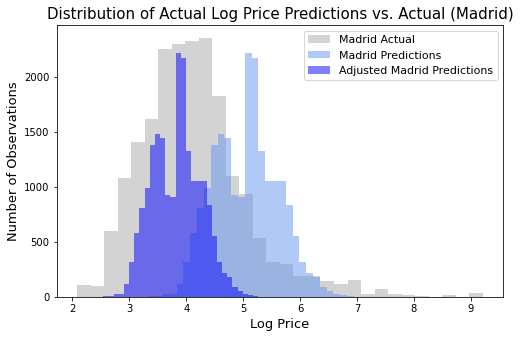

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(madrid_y, bins=30, label='Madrid Actual', color='darkgrey', alpha = 0.5)
plt.hist(y_pred_o, bins=30, label='Madrid Predictions', color='cornflowerblue',alpha = 0.5)
plt.hist(y_pred, bins=30, label='Adjusted Madrid Predictions', color='blue',alpha = 0.5)
plt.title('Distribution of Actual Log Price Predictions vs. Actual (Madrid)', fontsize=15)
plt.ylabel('Number of Observations', fontsize=13)
plt.xlabel('Log Price', fontsize=13)
plt.legend(fontsize=11)
plt.show()

#### London

In [166]:
# make predictions & time
lon_start = time.time()
y_pred_o = rf_final.predict(london_X)
lon_end = time.time()

# adjust predictions for cost of living
london_col = 100/95
y_pred = np.log(np.exp(y_pred_o / london_col))

# calculate metrics
acc = r2_score(london_y, y_pred)

rmse = mean_squared_error(np.exp(london_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(london_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(london_y), np.exp(y_pred))

In [167]:
print('Test Time (London):', round(lon_end-lon_start,2))
print('')
print('R^2 (London):', round(acc,3))
print('')
print('RMSE (London):', round(rmse,2))
print('')
print('Mean Abs Error (London):', round(mae,2))
print('')
print('Median Absolute Error (London):', round(medae,2))

Test Time (London): 33.17

R^2 (London): 0.455

RMSE (London): 304.68

Mean Abs Error (London): 55.43

Median Absolute Error (London): 27.33


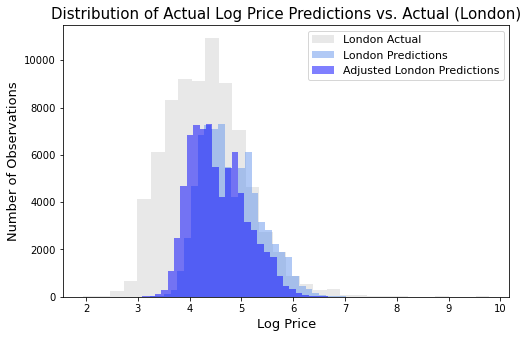

In [168]:
plt.figure(figsize=(8,5))
plt.hist(london_y, bins=30, label='London Actual', color='lightgrey', alpha = 0.5)
plt.hist(y_pred_o, bins=30, label='London Predictions', color='cornflowerblue',alpha = 0.5)
plt.hist(y_pred, bins=30, label='Adjusted London Predictions', color='blue',alpha = 0.5)
plt.title('Distribution of Actual Log Price Predictions vs. Actual (London)', fontsize=15)
plt.ylabel('Number of Observations', fontsize=13)
plt.xlabel('Log Price', fontsize=13)
plt.legend(fontsize=11)
plt.show()

#### Paris

In [142]:
# make predictions & time
paris_start = time.time()
y_pred_o = rf_final.predict(paris_X)
paris_end = time.time()

# adjust predictions for cost of living
paris_col = 100/89.3
y_pred = np.log(np.exp(y_pred_o / paris_col))

# calculate metrics
acc = r2_score(paris_y, y_pred)

rmse = mean_squared_error(np.exp(paris_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(paris_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(paris_y), np.exp(y_pred))

In [143]:
print('Test Time (Paris):', round(paris_end-paris_start,2))
print('')
print('R^2 (Paris):', round(acc,3))
print('')
print('RMSE (Paris):', round(rmse,2))
print('')
print('Mean Abs Error (Paris):', round(mae,2))
print('')
print('Median Absolute Error (Paris):', round(medae,2))

Test Time (Paris): 14.37

R^2 (Paris): 0.176

RMSE (Paris): 208.31

Mean Abs Error (Paris): 54.03

Median Absolute Error (Paris): 32.1


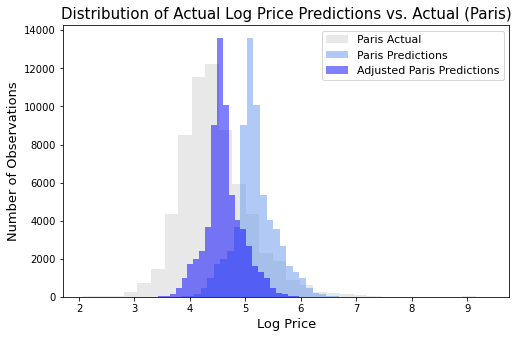

In [144]:
plt.figure(figsize=(8,5))
plt.hist(paris_y, bins=30, label='Paris Actual', color='lightgrey', alpha = 0.5)
plt.hist(y_pred_o, bins=30, label='Paris Predictions', color='cornflowerblue',alpha = 0.5)
plt.hist(y_pred, bins=30, label='Adjusted Paris Predictions', color='blue',alpha = 0.5)
plt.title('Distribution of Actual Log Price Predictions vs. Actual (Paris)', fontsize=15)
plt.ylabel('Number of Observations', fontsize=13)
plt.xlabel('Log Price', fontsize=13)
plt.legend(fontsize=11)
plt.show()

#### International

In [145]:
international_X = pd.concat([madrid_X, london_X, paris_X])
international_y = pd.concat([madrid_y, london_y, paris_y])

In [146]:
# make predictions & time
int_start = time.time()
y_pred_o = rf_final.predict(international_X)
int_end = time.time()

# adjust predictions for cost of living
int_col = 100/90.317413
y_pred = np.log(np.exp(y_pred_o / int_col))

# calculate metrics
acc = r2_score(international_y, y_pred)

rmse = mean_squared_error(np.exp(international_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(international_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(international_y), np.exp(y_pred))

In [147]:
print('Test Time (Int):', round(int_end-int_start,2))
print('')
print('R^2 (Int):', round(acc,3))
print('')
print('RMSE (Int):', round(rmse,2))
print('')
print('Mean Abs Error (Int):', round(mae,2))
print('')
print('Median Absolute Error (Int):', round(medae,2))

Test Time (Int): 37.53

R^2 (Int): 0.337

RMSE (Int): 295.93

Mean Abs Error (Int): 59.25

Median Absolute Error (Int): 28.29


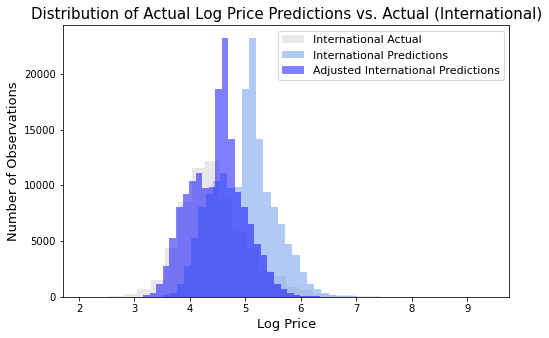

In [148]:
plt.figure(figsize=(8,5))
plt.hist(paris_y, bins=30, label='International Actual', color='lightgrey', alpha = 0.5)
plt.hist(y_pred_o, bins=30, label='International Predictions', color='cornflowerblue',alpha = 0.5)
plt.hist(y_pred, bins=30, label='Adjusted International Predictions', color='blue',alpha = 0.5)
plt.title('Distribution of Actual Log Price Predictions vs. Actual (International)', fontsize=15)
plt.ylabel('Number of Observations', fontsize=13)
plt.xlabel('Log Price', fontsize=13)
plt.legend(fontsize=11)
plt.show()

## Feature Importance

The impurity-based feature importances.

The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [117]:
importance = rf_final.feature_importances_

cols = list(X.columns)
imp_list = []

# summarize feature importance
for i,v in enumerate(importance):
    imp_list.append(v)
    
feature_imp = pd.DataFrame()
feature_imp['Feature'] = cols
feature_imp['Importance'] = imp_list
top5 = feature_imp.sort_values(by='Importance', ascending=False).head(5).reset_index(drop=True)
top10 = feature_imp.sort_values(by='Importance', ascending=False).head(10).reset_index(drop=True)

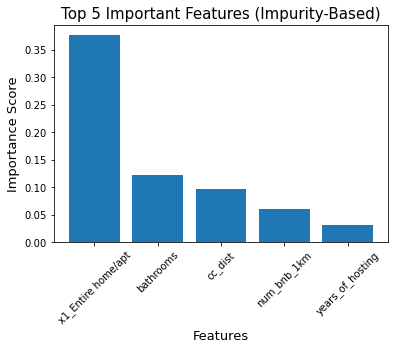

In [153]:
# plot feature importance
plt.bar('Feature', 'Importance', data=top5)
plt.xticks(rotation = 45)
plt.title('Top 5 Important Features (Impurity-Based)', fontsize=15)
plt.ylabel('Importance Score', fontsize=13)
plt.xlabel('Features', fontsize=13)
plt.show()

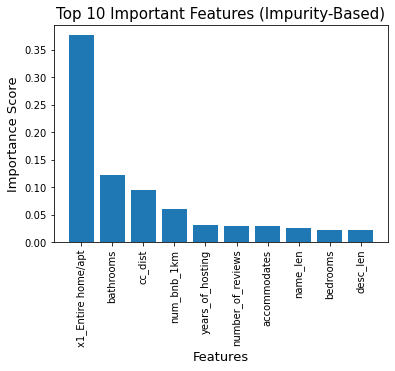

In [119]:
# plot feature importance
plt.bar('Feature', 'Importance', data=top10)
plt.xticks(rotation = 90)
plt.title('Top 10 Important Features (Impurity-Based)', fontsize=15)
plt.ylabel('Importance Score', fontsize=13)
plt.xlabel('Features', fontsize=13)
plt.show()